In [1]:
# ================================================================
# 1) SETUP: Mount Drive & Install Dependencies
# ================================================================
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install tensorflow keras opencv-python matplotlib seaborn shap lime scikit-image pyyaml

# Standard imports
import os
import yaml
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

from skimage.segmentation import mark_boundaries
from lime import lime_image
import shap

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=06914e07439ab2333856703816ff3a59b8a463774a6bfada3ca0a847976da5cd
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [19]:
# ================================================================
# 2) DATA PREPARATION: Build Label DataFrames
# ================================================================
import os
import pandas as pd
import yaml

BASE_DIR = '/content/drive/MyDrive/Fracatlas'   # adjust capitalization if needed

# Load YAML just for the class‐index → name mapping
with open(os.path.join(BASE_DIR, 'data.yaml')) as f:
    cfg = yaml.safe_load(f)
# cfg['names'] is a dict mapping 0→'no_fracture', 1→'femur', etc.

def build_df(split):
    img_dir = os.path.join(BASE_DIR, split, 'images')
    lbl_dir = os.path.join(BASE_DIR, split, 'labels')
    records = []

    for fname in os.listdir(img_dir):
        if not fname.lower().endswith(('.jpg','jpeg','png')):
            continue

        img_path = os.path.join(img_dir, fname)
        lbl_path = os.path.join(lbl_dir, os.path.splitext(fname)[0] + '.txt')

        # binary label: 0 if no file or empty file, else 1
        if not os.path.exists(lbl_path) or os.path.getsize(lbl_path) == 0:
            bin_lbl = 0
            region_lbl = 0
        else:
            bin_lbl = 1
            # YOLO‐style: first token in the first line is the class index
            with open(lbl_path) as lf:
                tokens = lf.readline().split()
            region_lbl = int(tokens[0])

        records.append({
            'image_path': img_path,
            'binary_label': bin_lbl,
            'region_label': region_lbl
        })

    return pd.DataFrame(records)

# Build the three splits
df_train = build_df('train')
df_val   = build_df('validation')
df_test  = build_df('test')

print(f"Train samples: {len(df_train)}")
print(f"Val   samples: {len(df_val)}")
print(f"Test  samples: {len(df_test)}")

Train samples: 574
Val   samples: 82
Test  samples: 61


In [3]:
# ================================================================
# 3) TF.DATA PIPELINE: Create Datasets for Binary & Multi‑Class
# ================================================================
IMG_SIZE = (224,224)
BATCH    = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)           # ResNet50 preprocess
    return img, label

def make_dataset(df, label_col, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((
        df['image_path'].values.astype(str),
        df[label_col].values.astype('int32')
    ))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

# Binary classification datasets
ds_train_bin = make_dataset(df_train, 'binary_label', shuffle=True)
ds_val_bin   = make_dataset(df_val,   'binary_label', shuffle=False)

# Multi-class on fractured images only
df_train_mc = df_train[df_train.binary_label==1].reset_index(drop=True)
df_val_mc   = df_val[df_val.binary_label==1].reset_index(drop=True)
ds_train_mc = make_dataset(df_train_mc, 'region_label', shuffle=True)
ds_val_mc   = make_dataset(df_val_mc,   'region_label', shuffle=False)

In [4]:
# ================================================================
# 4) BUILD & TRAIN BINARY FRACTURE DETECTOR
# ================================================================
# 4.1 Model definition
backbone = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))
x = GlobalAveragePooling2D()(backbone.output)
x = Dense(512, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)
binary_model = Model(inputs=backbone.input, outputs=out)

# 4.2 Freeze backbone
for layer in backbone.layers:
    layer.trainable = False

binary_model.compile(optimizer=Adam(1e-4),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# 4.3 Train
binary_history = binary_model.fit(
    ds_train_bin,
    epochs=10,
    validation_data=ds_val_bin
)

# 4.4 Save
os.makedirs(os.path.join(BASE_DIR,'models'), exist_ok=True)
binary_model.save(os.path.join(BASE_DIR,'models','binary_model.h5'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 162s 8s/step - accuracy: 0.6939 - loss: 0.6095 - val_accuracy: 0.0000e+00 - val_loss: 10.0645
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 62s 479ms/step - accuracy: 1.0000 - loss: 8.1616e-05 - val_accuracy: 0.0000e+00 - val_loss: 12.0366
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - accuracy: 1.0000 - loss: 2.1366e-05 - val_accuracy: 0.0000e+00 - val_loss: 12.4073
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 377ms/step - accuracy: 1.0000 - loss: 1.9368e-05 - val_accuracy: 0.0000e+00 - val_loss: 12.4787
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 396ms/step - accuracy: 1.0000 - loss: 2.2330e-05 - val_accuracy: 0.0000e+00 - val_loss: 12.4966
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 434ms/step - accuracy: 1.0000 - loss: 2.2019e-05 - val_accuracy: 0.0000e+00 - val_loss: 12.5062
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 463ms/step - accuracy: 1.0000 - loss: 1.5861e-05 - val_accuracy: 0.0000e+00 - val_loss:

In [5]:
# ================================================================
# 5) BUILD & TRAIN MULTI‑CLASS REGIONAL CLASSIFIER
# ================================================================
num_regions = len(cfg['names'])

backbone2 = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))
y = GlobalAveragePooling2D()(backbone2.output)
y = Dense(512, activation='relu')(y)
out2 = Dense(num_regions, activation='softmax')(y)
multi_model = Model(inputs=backbone2.input, outputs=out2)

for layer in backbone2.layers:
    layer.trainable = False

multi_model.compile(optimizer=Adam(1e-4),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

multi_history = multi_model.fit(
    ds_train_mc,
    epochs=10,
    validation_data=ds_val_mc
)

multi_model.save(os.path.join(BASE_DIR,'models','multi_model.h5'))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 630ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 889ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 414ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 439ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 448ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 347ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 439ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 362ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 958ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


Binary history keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Multi‑class history keys: dict_keys(['accuracy', 'loss'])


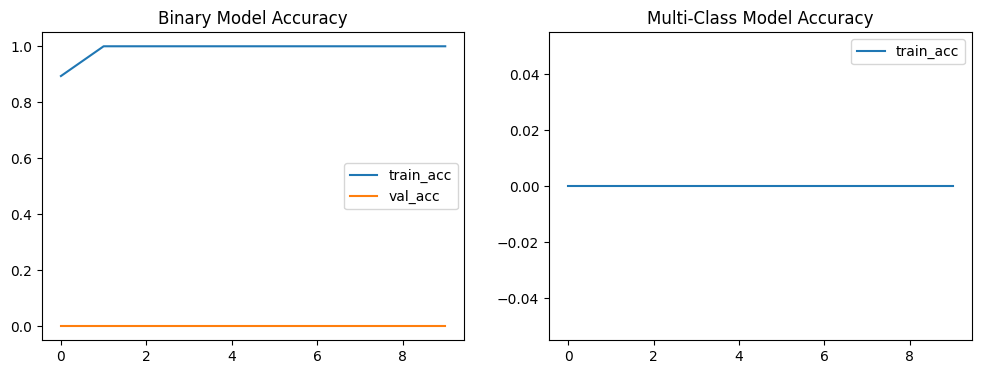

In [6]:
# === Inspect available keys ===
print("Binary history keys:", binary_history.history.keys())
print("Multi‑class history keys:", multi_history.history.keys())

# === Plot training & validation accuracy for both models ===
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# --- Binary Model ---
plt.subplot(1,2,1)
train_acc_b = binary_history.history.get('accuracy')
val_acc_b   = binary_history.history.get('val_accuracy')
plt.plot(train_acc_b, label='train_acc')
if val_acc_b is not None:
    plt.plot(val_acc_b, label='val_acc')
else:
    print("Warning: 'val_accuracy' not found for binary model.")
plt.title('Binary Model Accuracy')
plt.legend()

# --- Multi‑Class Model ---
plt.subplot(1,2,2)
train_acc_m = multi_history.history.get('accuracy')
# try both possible validation keys
val_acc_m = (multi_history.history.get('val_accuracy')
             or multi_history.history.get('val_sparse_categorical_accuracy'))
plt.plot(train_acc_m, label='train_acc')
if val_acc_m is not None:
    plt.plot(val_acc_m, label='val_acc')
else:
    print("Warning: No recognized 'val_accuracy' key found for multi‑class model.")
plt.title('Multi‑Class Model Accuracy')
plt.legend()

plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


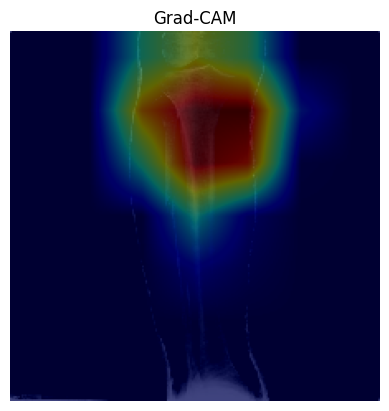

In [30]:
# ================================================================
# 7) XAI DEMOS: Grad‑CAM, SHAP, LIME, SALIENCY (BINARY MODEL)
# ================================================================
# Helper to load & preprocess single image
def prep_img(path):
    img = load_img(path, target_size=IMG_SIZE)
    arr = img_to_array(img)
    return np.expand_dims(preprocess_input(arr), axis=0), arr/255.0

test_image_path = '/content/drive/MyDrive/Fracatlas/test/images/IMG0003466.jpg'
inp_tensor, orig_disp = prep_img(test_image_path)

# --- 7a) GRAD‑CAM ---
# find last Conv2D layer automatically
for lyr in reversed(binary_model.layers):
    if isinstance(lyr, tf.keras.layers.Conv2D):
        last_conv = lyr.name
        break

def make_gradcam_heatmap(img_tensor, model, last_conv_layer_name):
    grad_model = Model([model.inputs],
                       [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor)
        idx = tf.argmax(preds[0])
        loss = preds[:, idx]
    grads = tape.gradient(loss, conv_out)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    heat = tf.tensordot(conv_out[0], pooled, axes=[2,0])
    heat = tf.maximum(heat,0) / tf.math.reduce_max(heat)
    return heat.numpy()

heatmap = make_gradcam_heatmap(inp_tensor, binary_model, last_conv)
plt.imshow(orig_disp)
plt.imshow(cv2.resize(heatmap, IMG_SIZE), cmap='jet', alpha=0.4)
plt.title('Grad‑CAM'); plt.axis('off'); plt.show()

SHAP map shape: (224, 3) min/max: 0.0 / 0.9998267748572602


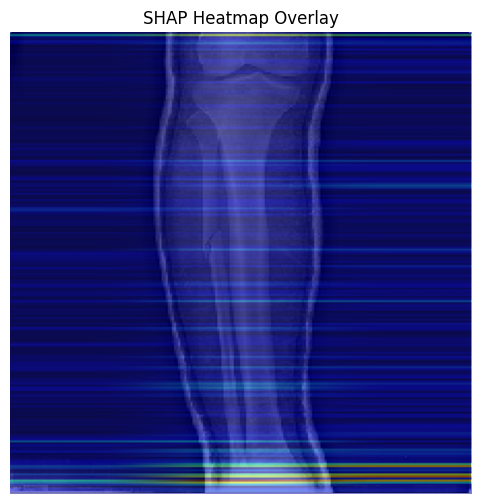

In [31]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- recompute your SHAP map exactly as before ---
# (bg_np, explainer, test_np, shap_vals, sv_map steps)

# 0) Quick sanity check:
print("SHAP map shape:", sv_map.shape,
      "min/max:", sv_map.min(), "/", sv_map.max())

# 1) Reload the raw RGB image for display
raw = img_to_array(load_img(test_image_path, target_size=IMG_SIZE)) / 255.0
# raw.shape should be (224,224,3) with values in [0,1]

# 2) Plot raw + SHAP overlay
plt.figure(figsize=(6,6))
plt.imshow(raw, vmin=0, vmax=1)                     # true RGB
plt.imshow(sv_map, cmap='jet', alpha=0.5,
           vmin=0, vmax=1, extent=(0,IMG_SIZE[1],IMG_SIZE[0],0))
plt.title('SHAP Heatmap Overlay')
plt.axis('off')
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━

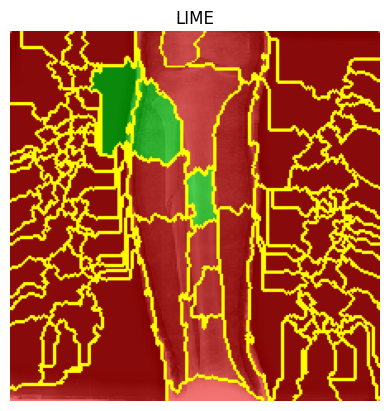

In [32]:
# --- 7c) LIME ---
def lime_pred(x):
    x = tf.image.resize(x, IMG_SIZE)
    x = preprocess_input(x)
    return binary_model.predict(x)

orig = img_to_array(load_img(test_image_path, target_size=IMG_SIZE))/255.0
expl = lime_image.LimeImageExplainer().explain_instance(
    image=orig, classifier_fn=lime_pred, top_labels=1, hide_color=0, num_samples=500
)
lbl = expl.top_labels[0]
segments = expl.segments
weights = dict(expl.local_exp[lbl])
thr = 0.5 * max(abs(w) for w in weights.values())
pos_mask = np.zeros(segments.shape, bool)
neg_mask = np.zeros(segments.shape, bool)
for seg_id,w in weights.items():
    (pos_mask if w>=thr else neg_mask)[segments==seg_id] = True
overlay = orig.copy()
overlay[pos_mask] = [0,1,0]
overlay[neg_mask] = [1,0,0]
blend = orig*0.5 + overlay*0.5
plt.imshow(mark_boundaries(blend,segments)); plt.title('LIME'); plt.axis('off'); plt.show()

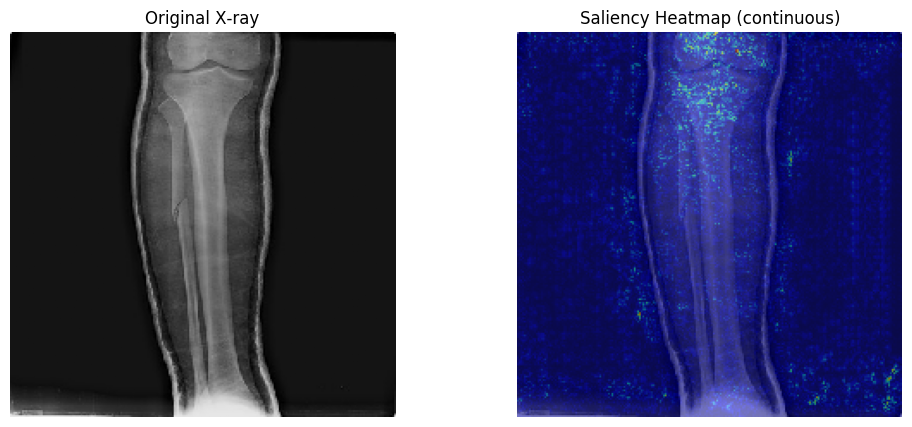

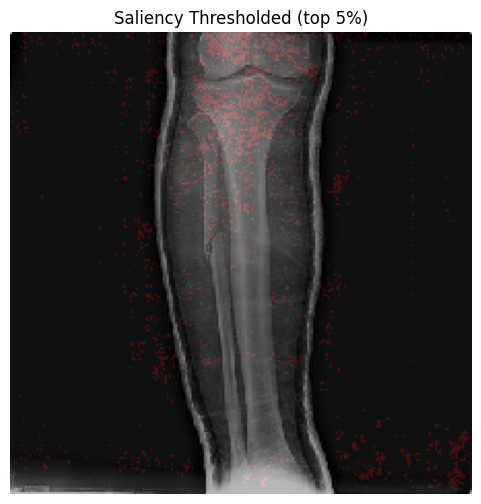

In [33]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- 7d) BETTER SALIENCY MAP VISUALIZATION ---

# 1) Compute gradients exactly as before
inp_tf = tf.convert_to_tensor(inp_tensor, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(inp_tf)
    prob = binary_model(inp_tf)[0][0]
grads = tape.gradient(prob, inp_tf)[0].numpy()   # (224,224,3)

# 2) Build a single‐channel saliency map
sal = np.max(np.abs(grads), axis=-1)            # (224,224)
sal_norm = (sal - sal.min()) / (sal.max() - sal.min() + 1e-10)

# 3) Reload the raw X‑ray in [0,1]
raw = img_to_array(load_img(test_image_path, target_size=IMG_SIZE)) / 255.0

# 4a) Continuous heatmap overlay
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(raw)
plt.title('Original X‑ray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(raw, vmin=0, vmax=1)
plt.imshow(sal_norm, cmap='jet', alpha=0.5, vmin=0, vmax=1)
plt.title('Saliency Heatmap (continuous)')
plt.axis('off')

plt.show()


# 4b) Optional: Binary highlight of top 5% pixels
threshold = np.percentile(sal_norm, 95)         # top 5%
mask = sal_norm >= threshold

ov = np.zeros((*IMG_SIZE, 3))
ov[mask] = [1.0, 0.0, 0.0]                      # red mask

blend = raw * 0.8 + ov * 0.2                   # lighter bone visibility
blend = np.clip(blend, 0, 1)

plt.figure(figsize=(6,6))
plt.imshow(blend)
plt.title('Saliency Thresholded (top 5%)')
plt.axis('off')
plt.show()
